#Using a SVC classifier to identify handwritten digits

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics, svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Dataset based on data found at [UCI ML](https://https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits)

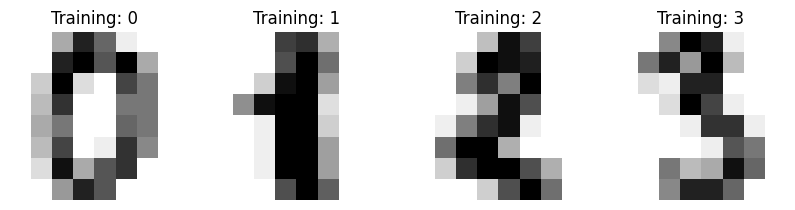

In [ ]:
digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

### Need to reshape the data into a 64 pixel grid and split the data into a test and train group

In [ ]:
# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.5, shuffle=False)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

###Displaying the outputs for 4 of the predicted outputs of our SVC linear model

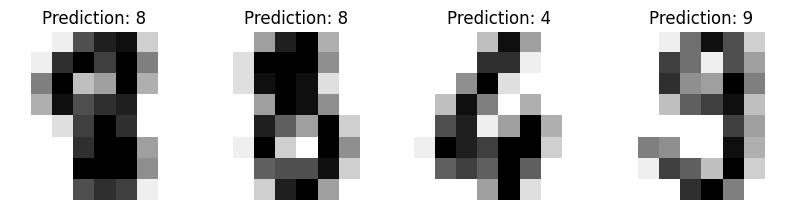

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}")

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899




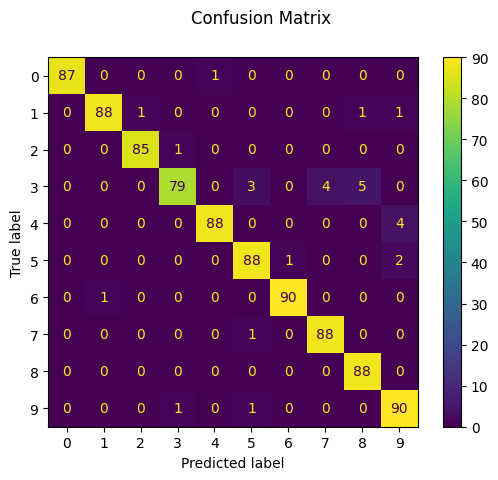

Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  1  1]
 [ 0  0 85  1  0  0  0  0  0  0]
 [ 0  0  0 79  0  3  0  4  5  0]
 [ 0  0  0  0 88  0  0  0  0  4]
 [ 0  0  0  0  0 88  1  0  0  2]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  1  0 88  0  0]
 [ 0  0  0  0  0  0  0  0 88  0]
 [ 0  0  0  1  0  1  0  0  0 90]]


In [ ]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
plt.show()
print(f"Confusion matrix:\n{disp.confusion_matrix}")

In [ ]:
# The ground truth and predicted lists
y_true = []
y_pred = []
cm = disp.confusion_matrix

# For each cell in the confusion matrix, add the corresponding ground truths
# and predictions to the lists
for gt in range(len(cm)):
    for pred in range(len(cm)):
        y_true += [gt] * cm[gt][pred]
        y_pred += [pred] * cm[gt][pred]

print(
    "Classification report rebuilt from confusion matrix:\n"
    f"{metrics.classification_report(y_true, y_pred)}\n"
)

Classification report rebuilt from confusion matrix:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899




# KMeans Clustering To Determine Digits

In [ ]:
data, labels = datasets.load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [ ]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.104s	69545	0.598	0.645	0.621	0.469	0.617	0.178
random   	0.093s	69735	0.681	0.723	0.701	0.574	0.698	0.159
PCA-based	0.028s	69513	0.600	0.647	0.622	0.468	0.618	0.155
__________________________________________________________________________________


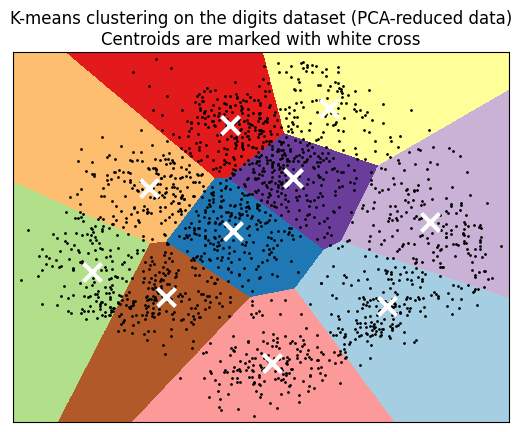

In [ ]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

#Using MLP Classifier on Found Data set

Data set found on Kaggle [DataSet](https://www.kaggle.com/datasets/fedesoriano/chinese-mnist-digit-recognizer/data)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
dfdigit = pd.read_csv('/content/drive/MyDrive/chineseMNIST.csv')

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

dfdigit['label'].replace(100,11,inplace=True)
dfdigit['label'].replace(1000,12,inplace=True)
dfdigit['label'].replace(10000,13,inplace=True)
dfdigit['label'].replace(100000000,14,inplace=True)

y = dfdigit['label']
colstodrop = ['label', 'character']
x = dfdigit.drop(columns=colstodrop)

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.5, random_state=0)



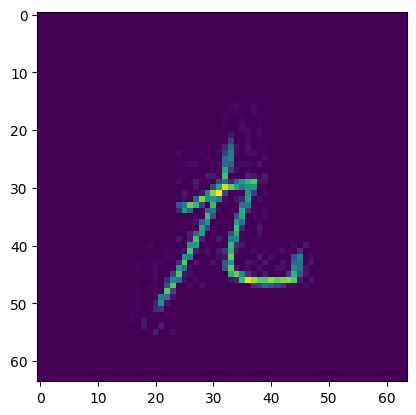

In [ ]:
plt.imshow(x.iloc[3].values.reshape(64, 64))


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

mdlnueral = MLPClassifier()

mdlnueral.fit(X_train, Y_train)

y_test_pred = mdlnueral.predict(X_test)

print("Classification Report:")
print(classification_report(Y_test, y_test_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.73       504
           1       0.86      0.88      0.87       526
           2       0.60      0.63      0.61       487
           3       0.67      0.58      0.62       515
           4       0.59      0.59      0.59       506
           5       0.56      0.46      0.51       517
           6       0.56      0.47      0.51       500
           7       0.54      0.56      0.55       510
           8       0.80      0.82      0.81       485
           9       0.47      0.46      0.47       486
          10       0.65      0.70      0.67       506
          11       0.45      0.51      0.48       498
          12       0.53      0.54      0.53       477
          13       0.45      0.52      0.48       486
          14       0.51      0.52      0.52       497

    accuracy                           0.60      7500
   macro avg       0.60      0.60      0.60      7500
wei

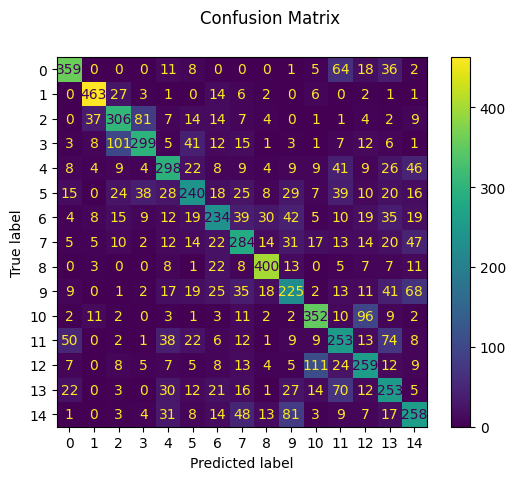

In [ ]:

disp = metrics.ConfusionMatrixDisplay.from_predictions(Y_test, y_test_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()